In [106]:
from lifelines import CoxPHFitter
from datetime import datetime
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from dateutil import relativedelta
from sklearn.metrics import auc

In [ ]:
from math import nan
df_train = pd.read_csv("df_train.csv")
df_test = pd.read_csv("df_test.csv")
# modified dataframes with high collinearity removed
df_train_mod = df_train[["ThirdPartyDollars","GrossApproval","TermInMonths", "GrossChargeOffAmount", "Term Multiple", "Same State", "In CA", "Is ThirdParty", "Missing Interest", "Refinance",  "Private Sector", "Premier", "CORPORATION", "INDIVIDUAL", "MISSING", "PARTNERSHIP", "SP500 YR", "Unemployment YR", "Avg Home Price", "GDP Delta YR", "Log S&P Open", "BorrState Unemployment","ProjectState Unemployment", "BorrState Income", "ProjState Income","Missing Borr Income", "BorrState GDP", "ProjState GDP", "Missing Borr GDP", "Missing Proj GDP","BorrState Vacancy","ProjectState Vacancy"]]
df_test_mod = df_test[["ThirdPartyDollars","GrossApproval","TermInMonths", "GrossChargeOffAmount", "Term Multiple", "Same State", "In CA", "Is ThirdParty", "Missing Interest", "Refinance",  "Private Sector", "Premier", "CORPORATION", "INDIVIDUAL", "MISSING", "PARTNERSHIP", "SP500 YR", "Unemployment YR", "Avg Home Price", "GDP Delta YR", "Log S&P Open", "BorrState Unemployment","ProjectState Unemployment", "BorrState Income", "ProjState Income","Missing Borr Income", "BorrState GDP", "ProjState GDP", "Missing Borr GDP", "Missing Proj GDP","BorrState Vacancy","ProjectState Vacancy"]]
df_train_mod['Event'] = df_train['LoanStatus'].apply(lambda x: 1 if x == "CHGOFF" else 0)
df_test_mod['Event'] = df_test['LoanStatus'].apply(lambda x: 1 if x == "CHGOFF" else 0)
df_test_mod = df_test_mod.reset_index()
train_duration = []
chgoff_train = np.array(df_train['ChargeOffDate'])
term_train = np.array(df_train['TermInMonths'])
app_train = np.array(df_train['ApprovalDate'])

for i in range(len(chgoff_train)):
  if pd.isna(chgoff_train[i]): train_duration.append(term_train[i])
  else:
    delt = relativedelta.relativedelta(datetime.strptime(chgoff_train[i], "%Y-%m-%d"), datetime.strptime(app_train[i], "%Y-%m-%d"))
    train_duration.append( delt.years*12 + delt.months)
df_train_mod['Duration'] = pd.Series(train_duration)

In [ ]:
cox = CoxPHFitter(penalizer=0.1)
cox.fit(df_train_mod, duration_col='Duration', event_col='Event')
survival = cox.predict_survival_function(df_test_mod)
survival.index = survival.index.astype(int)
default_prob = survival * -1 + 1
thres = np.linspace(0.000, 1.000, num=1001)

test_term = np.array(df_test_mod['TermInMonths'])
prob_at_term = []
for i, j in enumerate(test_term):
  prob_at_term.append(default_prob.iloc[default_prob.index.get_loc(j,method='backfill'), i])

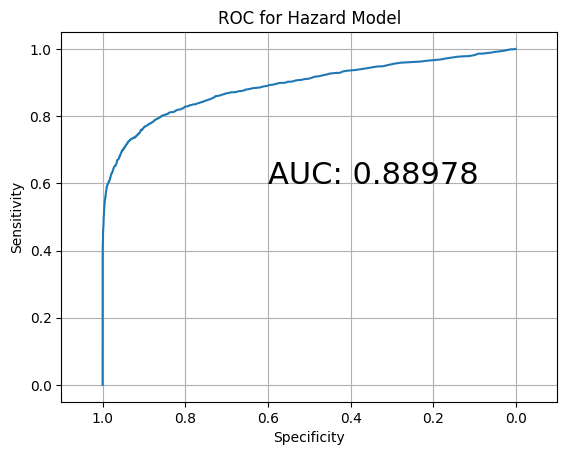

In [112]:
TP, TN = [], []
prob_at_term = np.array(prob_at_term)
for i in thres:
  typ = (prob_at_term > i).astype(int)
  # get true positive and negative for ROC
  tp = float(np.sum(np.logical_and(typ == 1, np.array(df_test_mod['Event']) == 1)))/np.sum(np.array(df_test_mod['Event']) == 1)
  tn = float(np.sum(np.logical_and(typ == 0, np.array(df_test_mod['Event']) == 0)))/np.sum(np.array(df_test_mod['Event']) == 0)
  TP.append(tp)
  TN.append(tn)
plt.plot(TN,TP)
plt.xlim(1.1, -0.1)
plt.title("ROC for Hazard Model")
plt.xlabel("Specificity")
plt.ylabel("Sensitivity")
plt.text(0.6, 0.6, 'AUC: ' + str(round(auc(TN,TP),5)), fontsize = 22)
plt.grid()